In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from tqdm import tqdm






In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [3]:
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'  # Update this path
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32,
                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

Dataset sizes: {'train': 5216, 'val': 16, 'test': 624}
Class names: ['NORMAL', 'PNEUMONIA']


In [4]:
def show_sample_images(dataloader, class_names, num_images=8):
    """Display sample images from the dataset"""
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()
    
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    
    for i in range(num_images):
        img = images[i]
        # Denormalize
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)
        
        axes[i].imshow(img.permute(1, 2, 0))
        axes[i].set_title(f'Class: {class_names[labels[i]]}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

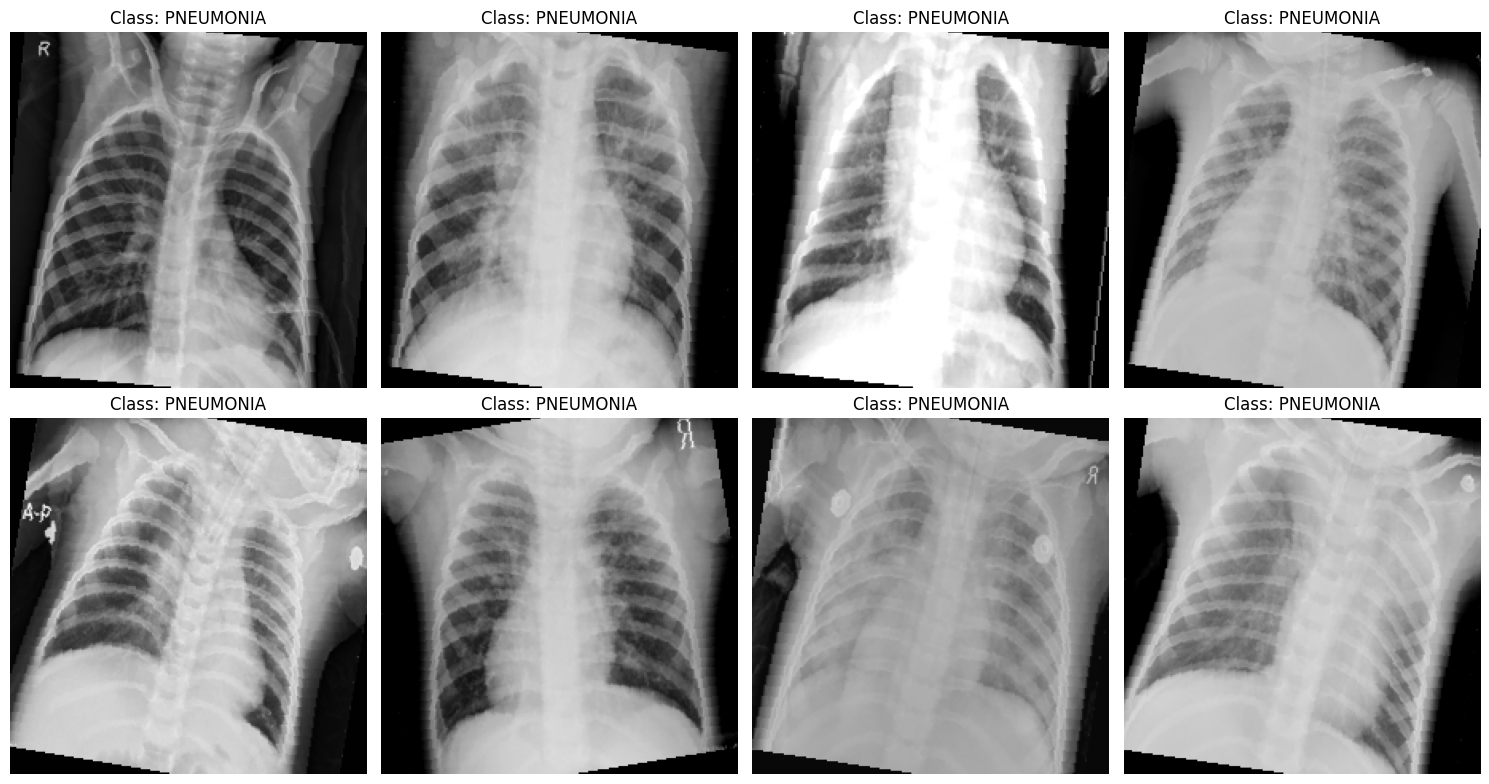

In [5]:
show_sample_images(dataloaders['train'], class_names)


In [6]:
def create_model(model_name='resnet50', num_classes=2, freeze_features=True):
    """
    Create a pre-trained model for transfer learning
    
    Args:
        model_name: 'resnet50', 'densenet121', or 'efficientnet_b0'
        num_classes: number of output classes
        freeze_features: whether to freeze feature extraction layers
    """
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        
        if freeze_features:
            for param in model.parameters():
                param.requires_grad = False
            # Only train the classifier
            for param in model.fc.parameters():
                param.requires_grad = True
                
    elif model_name == 'densenet121':
        model = models.densenet121(pretrained=True)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
        
        if freeze_features:
            for param in model.parameters():
                param.requires_grad = False
            for param in model.classifier.parameters():
                param.requires_grad = True
                
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=True)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        
        if freeze_features:
            for param in model.parameters():
                param.requires_grad = False
            for param in model.classifier.parameters():
                param.requires_grad = True
    
    return model

In [7]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10):
    """Train the model with early stopping and metrics tracking"""
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    patience = 5
    patience_counter = 0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            # Progress bar
            pbar = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch+1}')
            
            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Update progress bar
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{torch.sum(preds == labels.data).float()/inputs.size(0):.4f}'
                })
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Store metrics
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu().numpy())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.cpu().numpy())
                
                # Early stopping and best model saving
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1
                    
                if patience_counter >= patience:
                    print(f'Early stopping triggered after {epoch + 1} epochs')
                    break
        
        print()
        
        if patience_counter >= patience:
            break
    
    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    
    return model, {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs
    }

In [8]:
def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['train_losses'], label='Training Loss')
    ax1.plot(history['val_losses'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(history['train_accs'], label='Training Accuracy')
    ax2.plot(history['val_accs'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [9]:
def evaluate_model(model, test_loader, class_names):
    """Evaluate model on test set"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Calculate test accuracy
    test_acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Test Accuracy: {test_acc:.4f}")
    
    return all_preds, all_labels


Using device: cuda:0


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 208MB/s]


Model created: ResNet50
Device: cuda:0
Number of classes: 2
Starting training...
Model: ResNet50 (frozen features)
Total parameters: 23512130
Trainable parameters: 4098
Epoch 1/20
----------


Train Epoch 1: 100%|██████████| 163/163 [00:47<00:00,  3.45it/s, loss=0.1040, acc=0.9688]


Train Loss: 0.3036 Acc: 0.8740


Val Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.5782, acc=0.6250]


Val Loss: 0.5782 Acc: 0.6250

Epoch 2/20
----------


Train Epoch 2: 100%|██████████| 163/163 [00:41<00:00,  3.90it/s, loss=0.1841, acc=0.9375]


Train Loss: 0.1929 Acc: 0.9224


Val Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s, loss=0.4492, acc=0.7500]


Val Loss: 0.4492 Acc: 0.7500

Epoch 3/20
----------


Train Epoch 3: 100%|██████████| 163/163 [00:41<00:00,  3.91it/s, loss=0.2451, acc=0.9062]


Train Loss: 0.1658 Acc: 0.9346


Val Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s, loss=0.3548, acc=0.8125]


Val Loss: 0.3548 Acc: 0.8125

Epoch 4/20
----------


Train Epoch 4: 100%|██████████| 163/163 [00:41<00:00,  3.88it/s, loss=0.2650, acc=0.9062]


Train Loss: 0.1499 Acc: 0.9400


Val Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s, loss=0.8551, acc=0.5625]


Val Loss: 0.8551 Acc: 0.5625

Epoch 5/20
----------


Train Epoch 5: 100%|██████████| 163/163 [00:42<00:00,  3.88it/s, loss=0.0861, acc=0.9688]


Train Loss: 0.1583 Acc: 0.9373


Val Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s, loss=0.5355, acc=0.7500]


Val Loss: 0.5355 Acc: 0.7500

Epoch 6/20
----------


Train Epoch 6: 100%|██████████| 163/163 [00:41<00:00,  3.90it/s, loss=0.3617, acc=0.9062]


Train Loss: 0.1546 Acc: 0.9398


Val Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s, loss=0.1927, acc=0.9375]


Val Loss: 0.1927 Acc: 0.9375

Epoch 7/20
----------


Train Epoch 7: 100%|██████████| 163/163 [00:41<00:00,  3.91it/s, loss=0.1800, acc=0.9062]


Train Loss: 0.1432 Acc: 0.9444


Val Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s, loss=0.4095, acc=0.8125]


Val Loss: 0.4095 Acc: 0.8125

Epoch 8/20
----------


Train Epoch 8: 100%|██████████| 163/163 [00:42<00:00,  3.86it/s, loss=0.1905, acc=0.9375]


Train Loss: 0.1367 Acc: 0.9469


Val Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s, loss=0.4555, acc=0.7500]


Val Loss: 0.4555 Acc: 0.7500

Epoch 9/20
----------


Train Epoch 9: 100%|██████████| 163/163 [00:41<00:00,  3.91it/s, loss=0.1883, acc=0.8750]


Train Loss: 0.1288 Acc: 0.9503


Val Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s, loss=0.3947, acc=0.8125]


Val Loss: 0.3947 Acc: 0.8125

Epoch 10/20
----------


Train Epoch 10: 100%|██████████| 163/163 [00:41<00:00,  3.92it/s, loss=0.0841, acc=0.9688]


Train Loss: 0.1293 Acc: 0.9507


Val Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s, loss=0.4692, acc=0.8125]


Val Loss: 0.4692 Acc: 0.8125

Epoch 11/20
----------


Train Epoch 11: 100%|██████████| 163/163 [00:42<00:00,  3.86it/s, loss=0.1506, acc=0.9375]


Train Loss: 0.1269 Acc: 0.9526


Val Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s, loss=0.4360, acc=0.8125]


Val Loss: 0.4360 Acc: 0.8125
Early stopping triggered after 11 epochs

Best val Acc: 0.937500


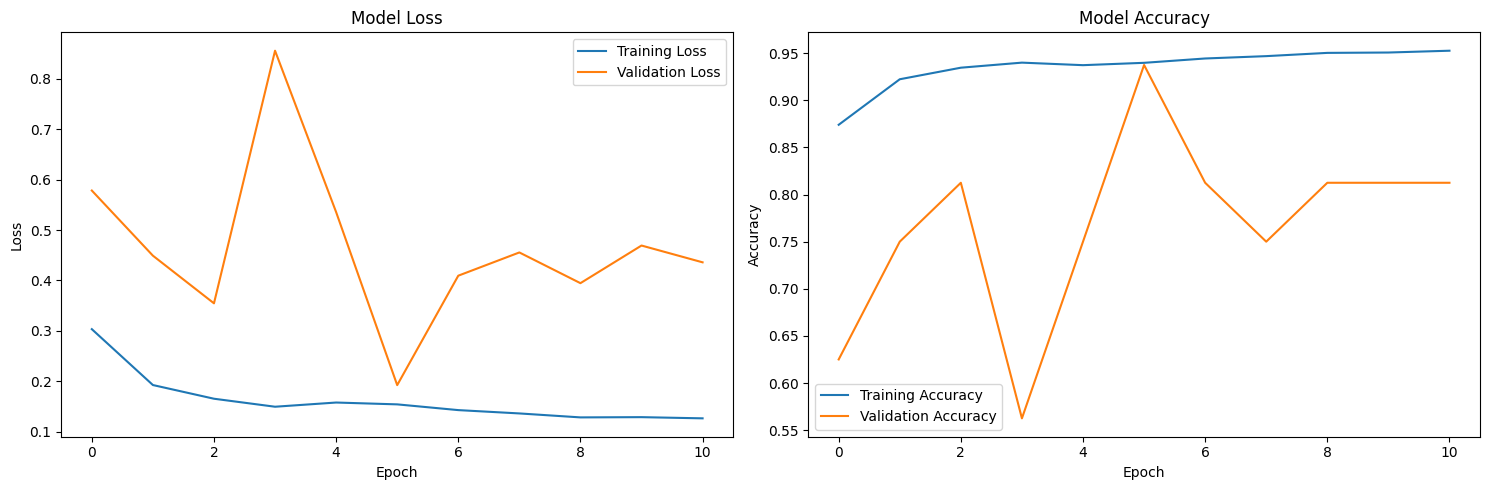


Evaluating on test set...


Testing: 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.93      0.62      0.74       234
   PNEUMONIA       0.81      0.97      0.88       390

    accuracy                           0.84       624
   macro avg       0.87      0.79      0.81       624
weighted avg       0.85      0.84      0.83       624



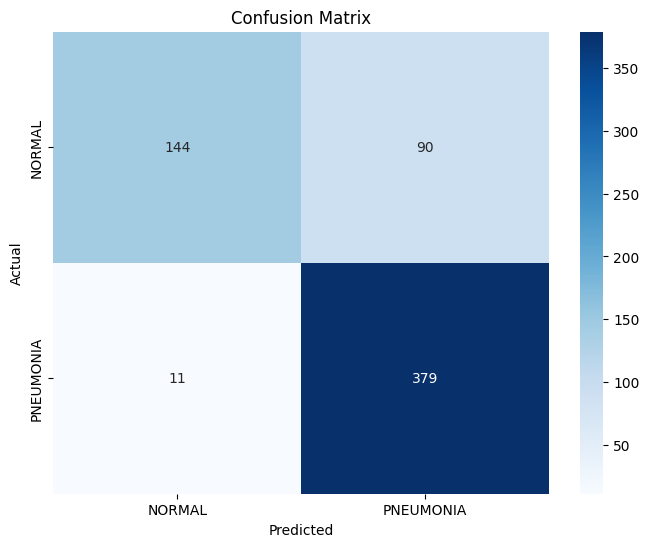

Test Accuracy: 0.8381
Model saved as 'pneumonia_classifier.pth'

=== Fine-tuning Phase ===
Unfreezing last few layers for fine-tuning...
Epoch 1/10
----------


Train Epoch 1: 100%|██████████| 163/163 [00:43<00:00,  3.76it/s, loss=0.1655, acc=0.9688]


Train Loss: 0.1313 Acc: 0.9523


Val Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s, loss=2.3676, acc=0.6875]


Val Loss: 2.3676 Acc: 0.6875

Epoch 2/10
----------


Train Epoch 2: 100%|██████████| 163/163 [00:43<00:00,  3.73it/s, loss=0.0030, acc=1.0000]


Train Loss: 0.0792 Acc: 0.9701


Val Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s, loss=0.1153, acc=1.0000]


Val Loss: 0.1153 Acc: 1.0000

Epoch 3/10
----------


Train Epoch 3: 100%|██████████| 163/163 [00:43<00:00,  3.77it/s, loss=0.0892, acc=0.9688]


Train Loss: 0.0580 Acc: 0.9789


Val Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s, loss=0.8629, acc=0.6875]


Val Loss: 0.8629 Acc: 0.6875

Epoch 4/10
----------


Train Epoch 4: 100%|██████████| 163/163 [00:43<00:00,  3.76it/s, loss=0.0102, acc=1.0000]


Train Loss: 0.0462 Acc: 0.9826


Val Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s, loss=0.1137, acc=0.9375]


Val Loss: 0.1137 Acc: 0.9375

Epoch 5/10
----------


Train Epoch 5: 100%|██████████| 163/163 [00:43<00:00,  3.72it/s, loss=0.0290, acc=1.0000]


Train Loss: 0.0384 Acc: 0.9872


Val Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s, loss=0.3619, acc=0.7500]


Val Loss: 0.3619 Acc: 0.7500

Epoch 6/10
----------


Train Epoch 6: 100%|██████████| 163/163 [00:43<00:00,  3.75it/s, loss=0.0136, acc=1.0000]


Train Loss: 0.0257 Acc: 0.9896


Val Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s, loss=0.1939, acc=0.8750]


Val Loss: 0.1939 Acc: 0.8750

Epoch 7/10
----------


Train Epoch 7: 100%|██████████| 163/163 [00:43<00:00,  3.79it/s, loss=0.0011, acc=1.0000]


Train Loss: 0.0201 Acc: 0.9942


Val Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s, loss=0.2068, acc=0.8125]


Val Loss: 0.2068 Acc: 0.8125
Early stopping triggered after 7 epochs

Best val Acc: 1.000000

Final evaluation after fine-tuning...


Testing: 100%|██████████| 20/20 [00:05<00:00,  3.75it/s]


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.59      0.74       234
   PNEUMONIA       0.80      0.99      0.89       390

    accuracy                           0.84       624
   macro avg       0.89      0.79      0.82       624
weighted avg       0.87      0.84      0.83       624



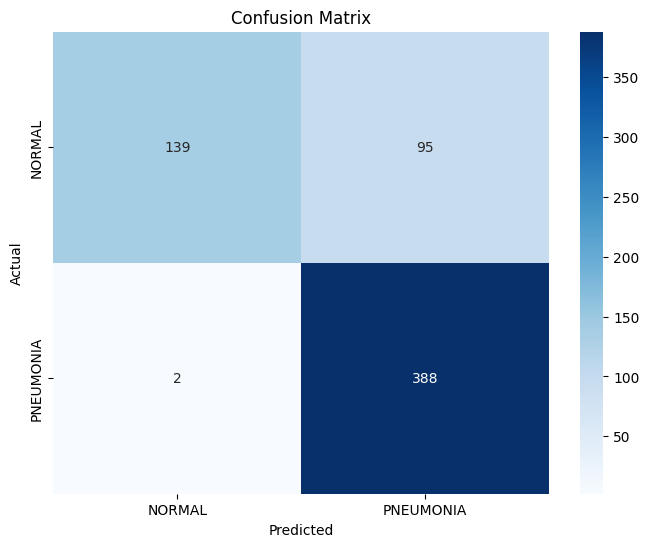

Test Accuracy: 0.8446
Fine-tuned model saved as 'pneumonia_classifier_finetuned.pth'


In [10]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create the model
model = create_model(model_name='resnet50', num_classes=2, freeze_features=True)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print(f"Model created: ResNet50")
print(f"Device: {device}")
print(f"Number of classes: {len(class_names)}")
print("Starting training...")
print(f"Model: ResNet50 (frozen features)")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Train the model
trained_model, history = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=20)

# Plot training history
plot_training_history(history)

# Evaluate on test set
print("\nEvaluating on test set...")
test_preds, test_labels = evaluate_model(trained_model, dataloaders['test'], class_names)

# Save the model
torch.save(trained_model.state_dict(), 'pneumonia_classifier.pth')
print("Model saved as 'pneumonia_classifier.pth'")

# Example of fine-tuning (unfreezing some layers)
print("\n=== Fine-tuning Phase ===")
print("Unfreezing last few layers for fine-tuning...")

# Unfreeze the last residual block
for param in trained_model.layer4.parameters():
    param.requires_grad = True

# Lower learning rate for fine-tuning
optimizer = optim.Adam(trained_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Fine-tune for a few more epochs
finetuned_model, ft_history = train_model(trained_model, dataloaders, criterion, optimizer, scheduler, num_epochs=10)

# Final evaluation
print("\nFinal evaluation after fine-tuning...")
final_preds, final_labels = evaluate_model(finetuned_model, dataloaders['test'], class_names)

# Save final model
torch.save(finetuned_model.state_dict(), 'pneumonia_classifier_finetuned.pth')
print("Fine-tuned model saved as 'pneumonia_classifier_finetuned.pth'")

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Or whatever you used in training
])

# ----------------------
# 4. Streamlit UI
# ----------------------

st.title("🩺 Pneumonia Detection from Chest X-ray")
st.write("Upload a chest X-ray image below. The model will predict whether the image shows signs of pneumonia.")

uploaded_file = st.file_uploader("Upload Image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    img = Image.open(uploaded_file).convert("RGB")
    st.image(img, caption='Uploaded Image', use_column_width=True)

    # Preprocess
    img_tensor = transform(img).unsqueeze(0)

    # Predict
    with torch.no_grad():
        output = model(img_tensor)
        prob = output.item()
        label = "Pneumonia" if prob > 0.5 else "Normal"
        confidence = prob if label == "Pneumonia" else 1 - prob

    st.subheader(f"Prediction: {label}")
    st.write(f"Confidence: {confidence:.2%}")